## Chapter 9 Linear two class classification

# 9.4  Feature scaling via standard normalization

In this Section we discuss the benefits of *normalizing input features* - also called *feature scaling* - via the *standard normalization scheme* (i.e., subtracting the mean and dividing off the standard deviation of each feature) for linear two class classification in terms of how it helps drastically improve training speed when using gradient descent (and coordinate descent methods).  This closely mirrors the discussion of the same topic for linear regression in Section 8.4.  Input normalization is one of simplest yet most effective 'optimization tricks' one can use when employing gradient descent to tune *any supervised learning model*.  This 'optimization trick' will also prove especially important when we deal with nonlinear supervised models in the future - like e.g., *deep networks* - where training via gradient descent (and its close relatives) is essential.

In [ ]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# demos for this notebook
classif_plotter = superlearn.lin_classification_demos
optimizers = optlib.optimizers
classification_plotter = superlearn.classification_static_plotter.Visualizer();
feature_scaling_tools = superlearn.feature_scaling_tools
static_plotter = optlib.static_plotter.Visualizer()
cost_lib = superlearn.cost_functions
normalizers = superlearn.normalizers 

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 9.4.1 Feature scaling for single input datasets

Below we load in a simple two class dataset with $N=1$ input feature.  A quick glance at the data and we can intuit that - if tuned properly - a two class linear classifier will perform very well on this dataset, as the data appears to be largely separable by a zero-dimensional line (i.e., a point).

<IPython.core.display.Javascript object>


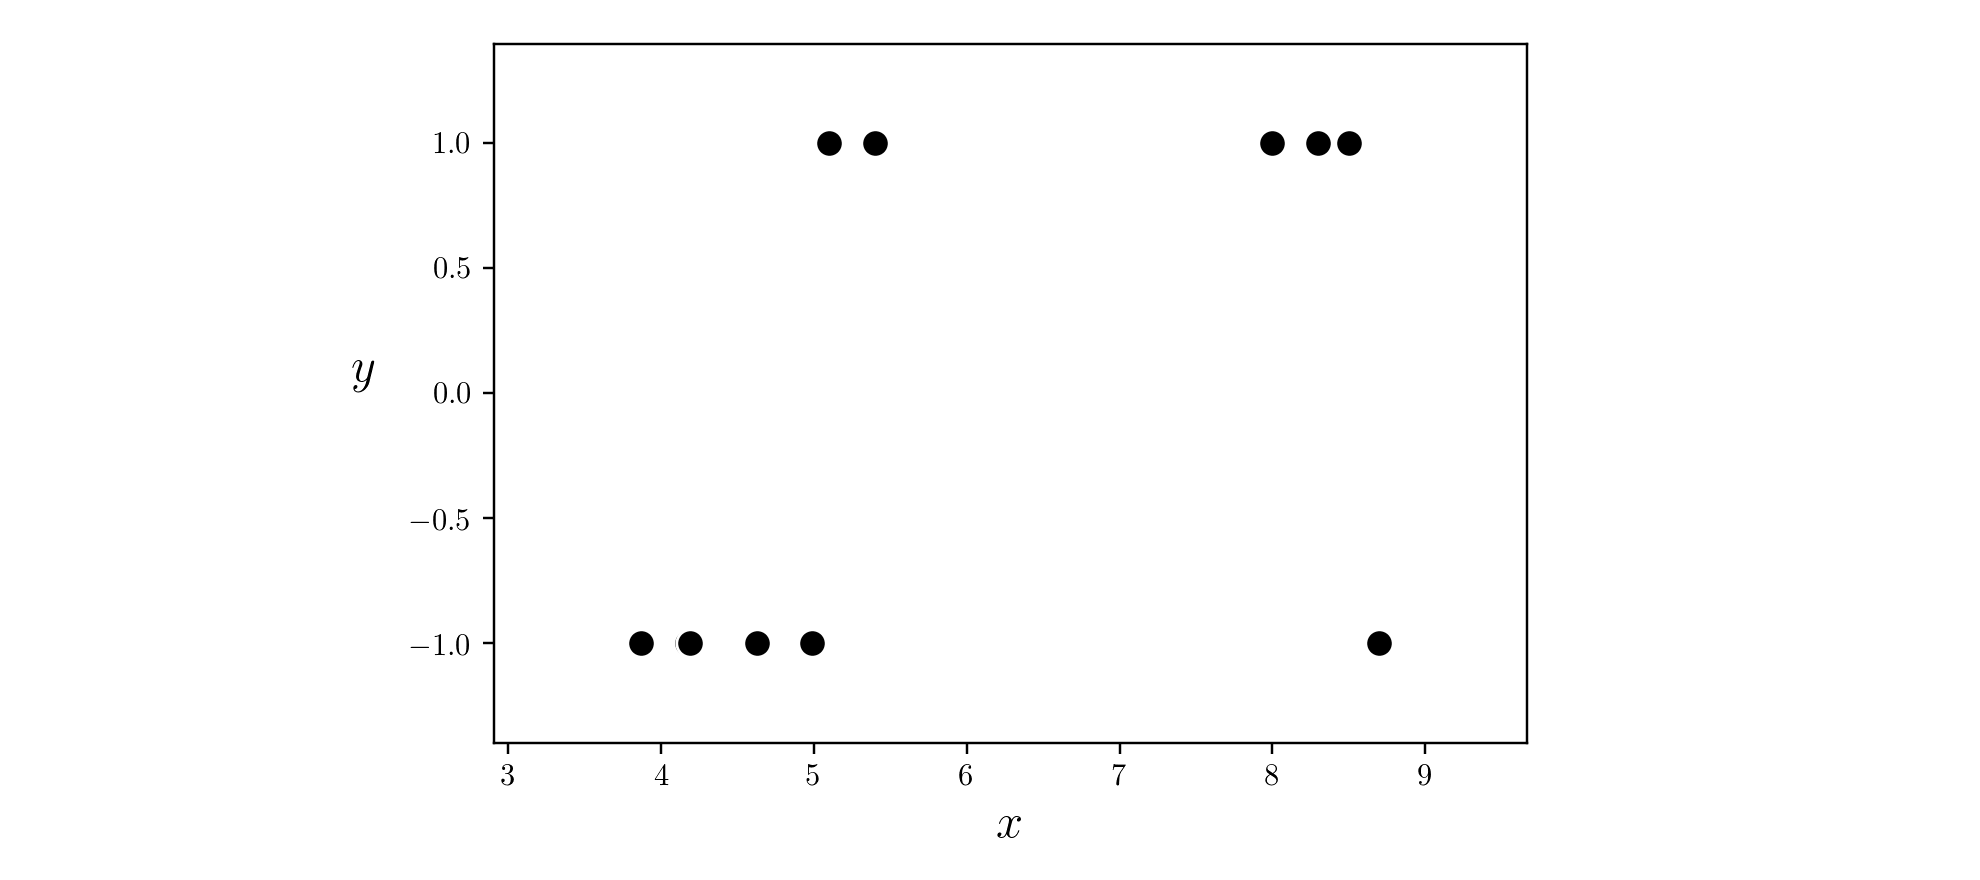

In [35]:
# load in dataset
data = np.loadtxt(datapath + '2d_classification_data_v1.csv')

# get input/output pairs
x = data[:,:-1:].T + 4
y = data[:,-1:] 
y[-1] = -1

# reform data with adjustments
data = np.concatenate((x.T,y),axis = 1)

# plot dataset
demo = classif_plotter.Visualizer(data)
demo.plot_data()

Since we only need properly tune two parameters in learning a linear classifier for this dataset, we can visualize any classification cost function over it.  Here we will use the softmax cost.  Below we load in this cost function from a backend file - containing precisely the softmax cost implemented in Section 9.1 - and then show its contour plot over the above dataset.

The contours of this function are extremely long and narrow - and so we can predict that gradient descent will struggle immensely (zig-zagging very slowly - as we first described in Section 6.4, and discussed again in Section 8.4) in determining the global minimum (located inside the smallest contour shown below). 

In [29]:
# load in cost function
softmax = cost_lib.Setup(x,y,'softmax').cost_func
counting_cost = cost_lib.Setup(x,y,'counter').cost_func

<IPython.core.display.Javascript object>


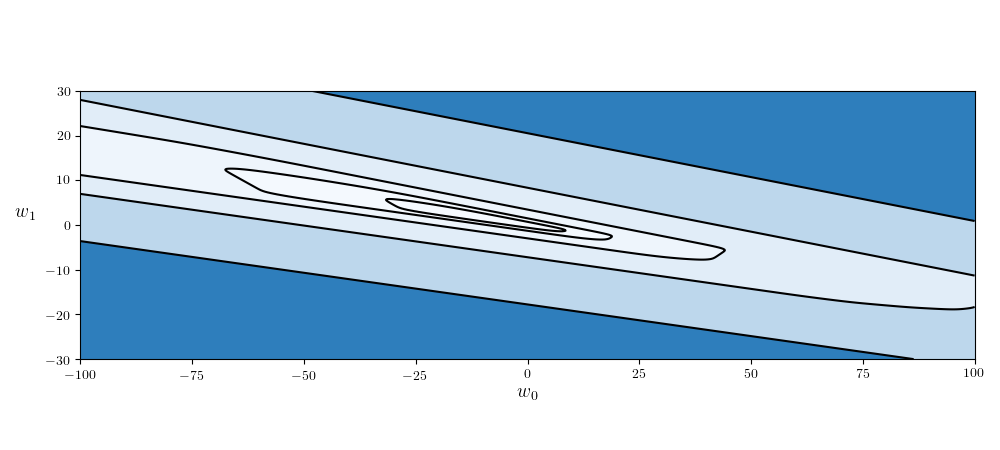

In [4]:
# show the contours of an input function over a desired viewing range
static_plotter.two_input_contour_plot(softmax,[],xmin = -100,xmax = 100,ymin = -30,ymax = 30,num_contours = 5,show_original = False)

We can confirm this intuition regarding gradient descent by making a run - which we do below.  Beginning at the point $\mathbf{w} = \begin{bmatrix} 20 \\ 30 \end{bmatrix}$ we visualize $100$ steps of gradient descent with a fixed steplength $\alpha = 1$.  This was the largest steplength size of the form $10^{-\gamma}$ with $\gamma$ an integer that we found that did not cause gradient descent to diverge here.mm

In [30]:
# load in an optimizer
g = softmax; w = np.array([20.0,30.0])[:,np.newaxis]; max_its = 100; alpha_choice = 1;
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_1 = [counting_cost(v) for v in weight_history_1]  # compute misclassification history

<IPython.core.display.Javascript object>


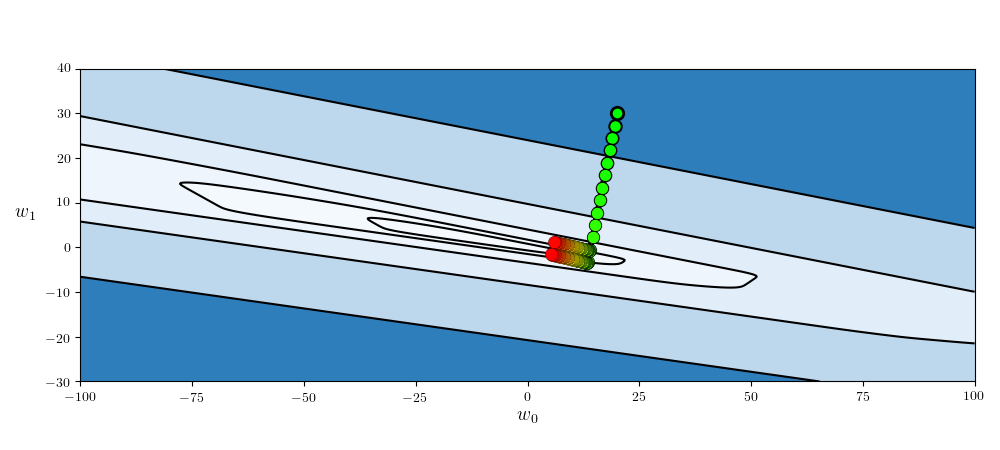

In [22]:
# show run on contour plot
static_plotter.two_input_contour_plot(softmax,weight_history_1,xmin = -100,xmax = 100,ymin = -30,ymax = 40,num_contours = 5,show_original = False)

Here as usual the steps are colored from green to red as gradient descent begins (green) to when it ends (red).  From this perspective we can see that we still have a long way to travel to reach the minimum of the cost function, and that these steps will likely continue to zig-zag considerably. 

Plotting the logistic sigmoid (in red) and associated counting cost function (in blue) given by the final set of weights learned in this run of gradient descent - those associated with the final red point plotted on the contour plot above - we can see that the fact that these weights lie so far from the true minimum of the cost function truly affect the classifier's quality immensely - we learn a poor classifier here. 

<IPython.core.display.Javascript object>


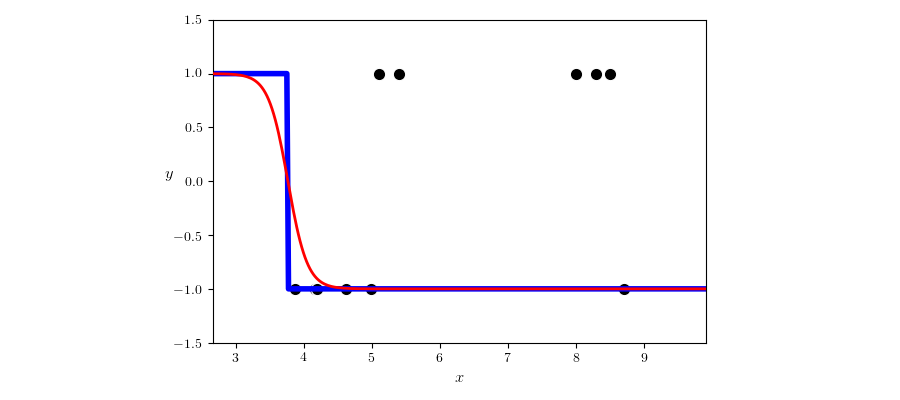

In [23]:
# the original data and the best learned logistic sigmoid and counting cost
# line learned from our gradient descent run above
ind = np.argmin(count_history_1)
best_weights = weight_history_1[ind]
demo.plot_fit(best_weights)

In Section 8.4 we saw how normalizing input drastically improved the topology of linear regression cost functions, making it much easier for gradient descent (as well as other local optimization methods) to find global minima and hence learn a proper linear regressor.  Here will see how input normalization or *feature scaling* using the *standard normalization* scheme first discussed in Section 8.4, as it provides precisely the same benefit in the context of two class linear classification.

Thus we will normalize our our input by subtracting off its mean and dividing by its standard deviation - precisely as we did in Section 8.4 with linear regression.  This means we will replace each input $x_p$ point with its mean centered unit deviation analog as 

\begin{equation}
x_p \longleftarrow \frac{x_p - \mu}{\sigma}
\end{equation}

where the sample mean of the inputs $\mu$ is defined as 

\begin{equation}
\mu = \frac{1}{P}\sum_{p=1}^{P}x_p \\
\end{equation}

and the sample standard deviation of the inputs $\sigma$ is defined as 

\begin{array}
\
\sigma = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_p - \mu \right)^2}.
\end{array}

As we will see below for the particular dataset we are currently studying, this simple normalization 'trick' has a profound impact on the shape of our cost function.  Also note: this normalization scheme is *invertible*, meaning that after performing it we can always return to our original data by simple re-multiplying a normalized input by the original standard deviation and adding the original mean. 

We developed ``Python`` functionality to perform this normalization in Section 8.4, and load in this scheme from a backend file called ``normalizers``.  Below we load in this code and employ it.

In [36]:
# create normalizer
normalizer = normalizers.standard_normalizer(x)

# normalize input
x_normalized = normalizer(x)

Lets now examine the contours of the softmax cost function using the normalized input.  As we can see below, the contours of this cost function are drastically improved.

<IPython.core.display.Javascript object>


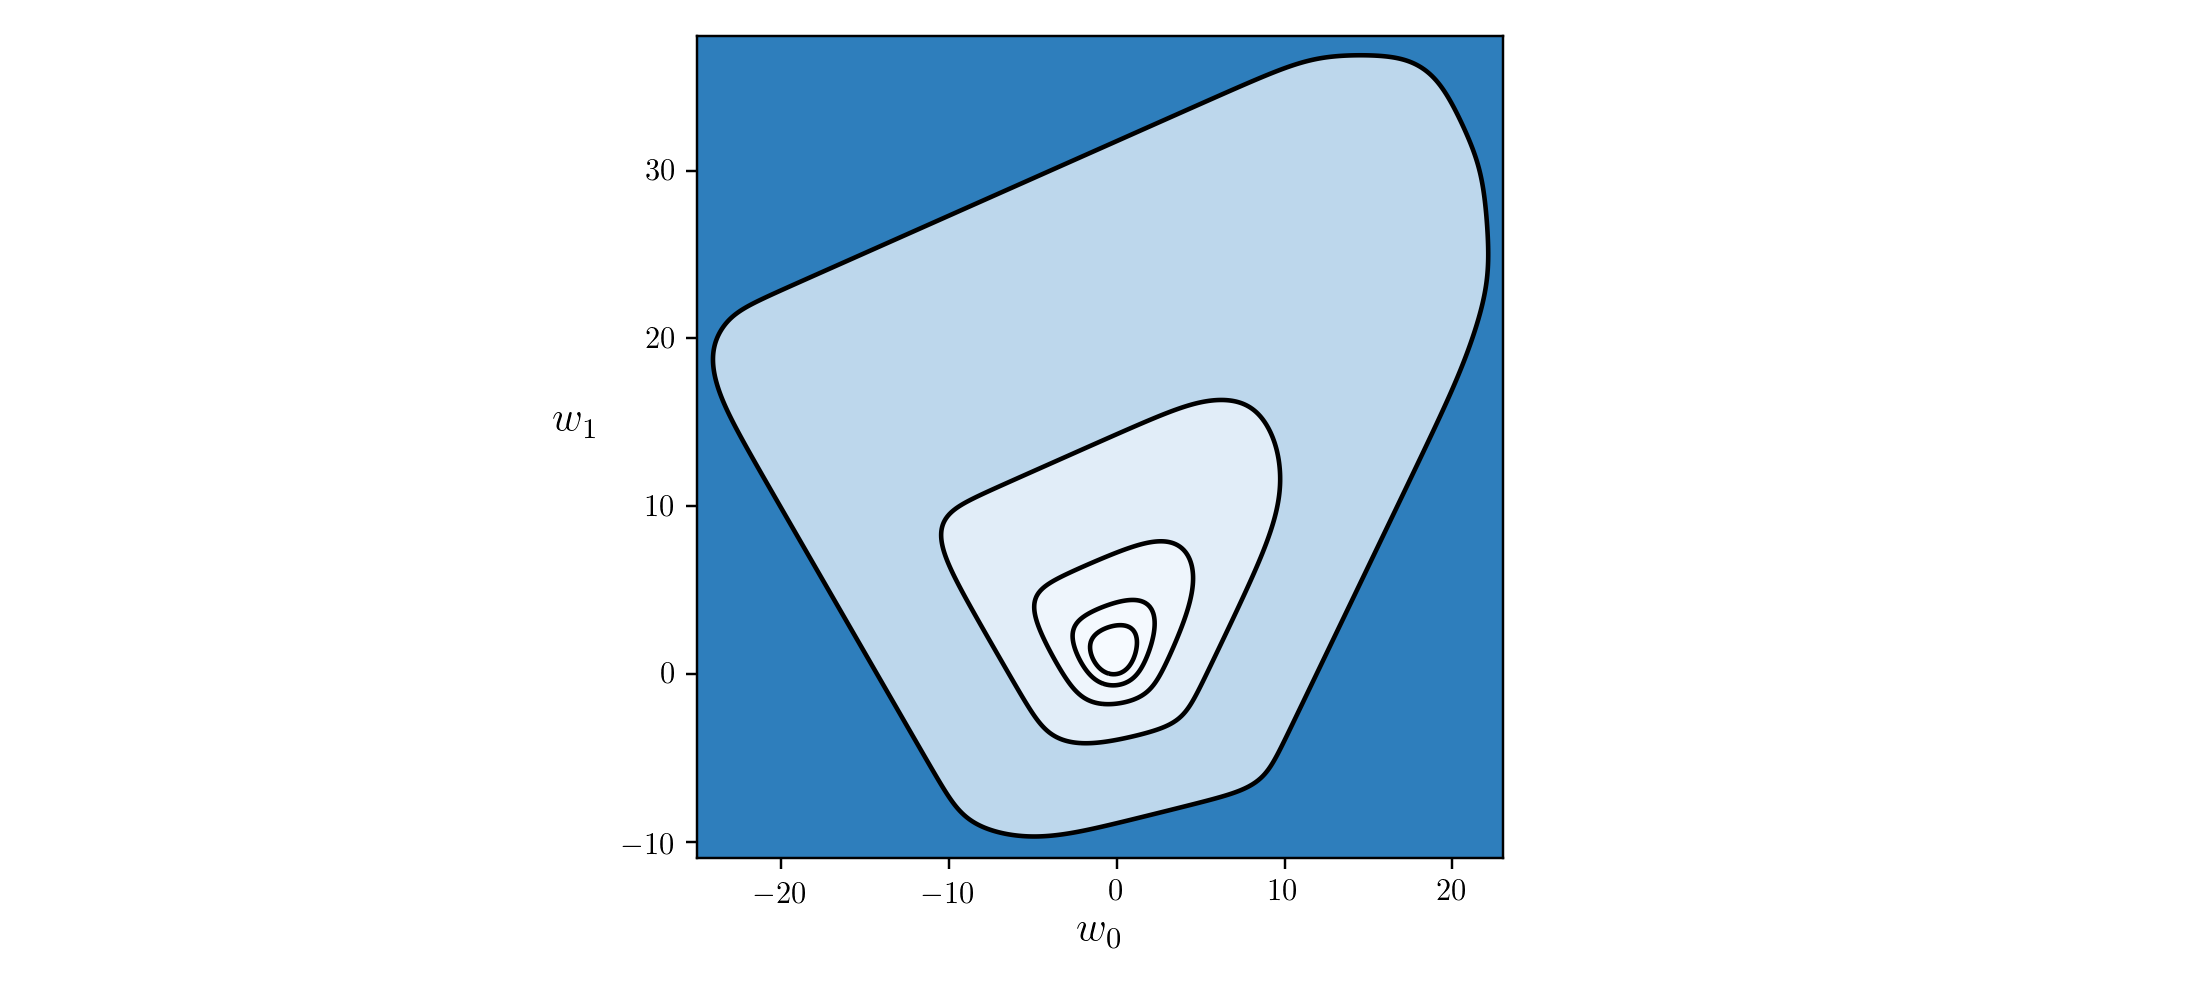

In [37]:
# define new cost with normalized data
softmax_2 = cost_lib.Setup(x_normalized,y,'softmax').cost_func

# show the contours of an input function over a desired viewing range
static_plotter.two_input_contour_plot(softmax_2,[],xmin = -25,xmax = 23,ymin = -11,ymax = 38,num_contours = 5,show_original = False)

Below we show an animation where we form a sequence of softmax cost functions using a convex combination of the original and normalized data 

\begin{equation}
\left(1 - \lambda\right)x_p + \lambda \left( \frac{x_p - \mu}{\sigma} \right)
\end{equation}

where $\lambda$ ranges from $0$ (i.e., we use the original input) to $\lambda = 1$ (where we use the normalized versions).  Plotting the contour of each softmax cost for a $50$ evenly spaced values of $\lambda$ between $0$ and $1$ shows how the original softmax cost function is transformed by normalizing the input.  You can use the slider below to transition between the contours of the original cost function (when the slider is all the way to the left) and cost function taking in normalized input (when the slider is all the way to the right).  


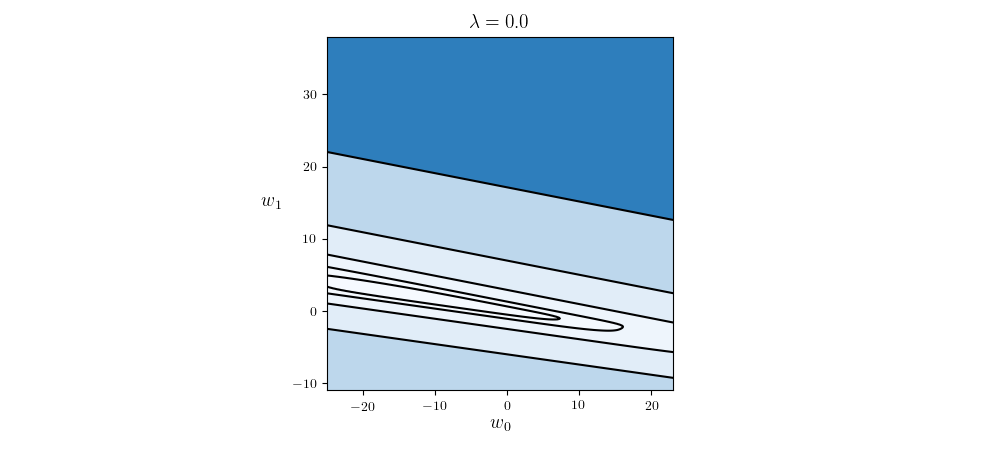
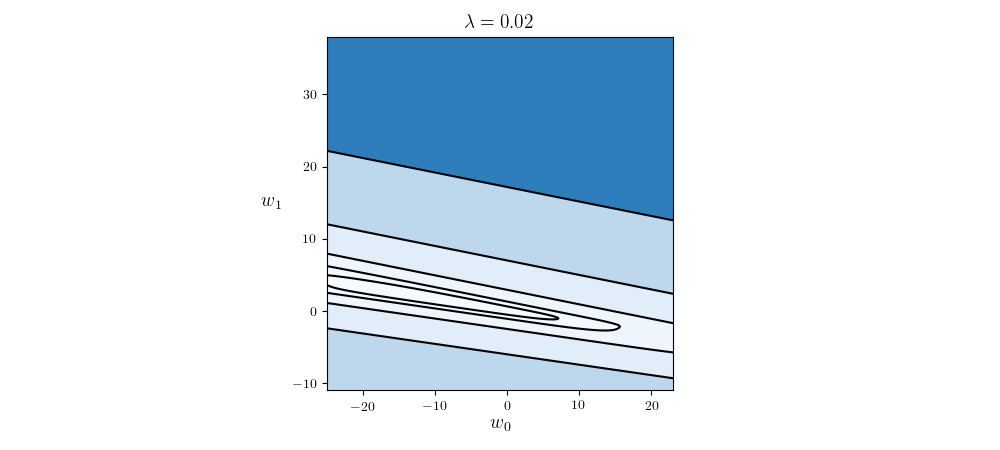
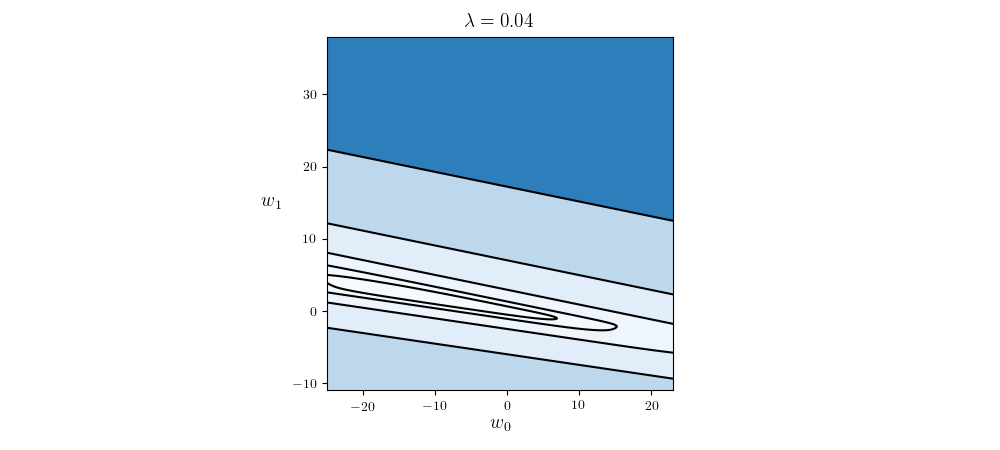
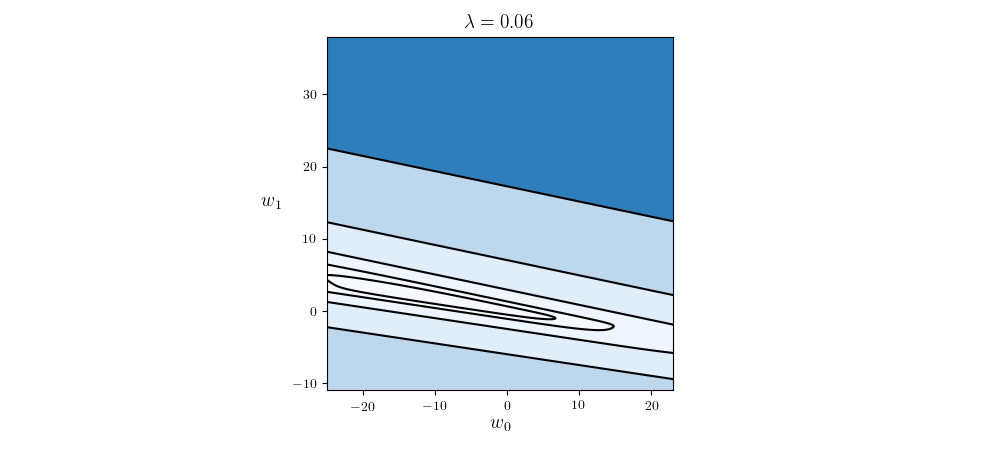
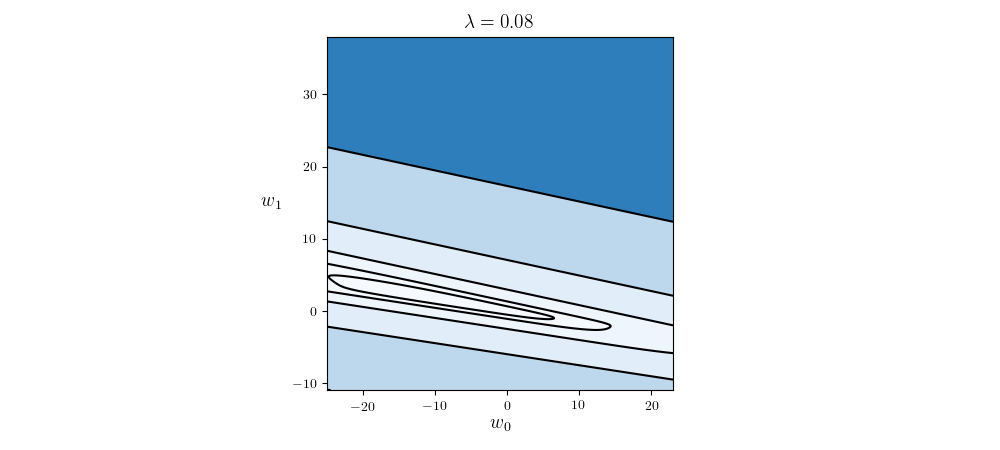
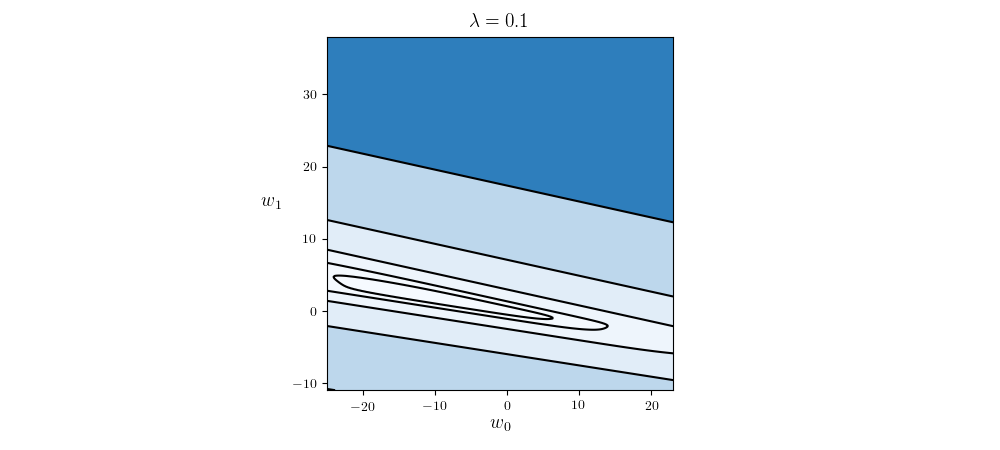
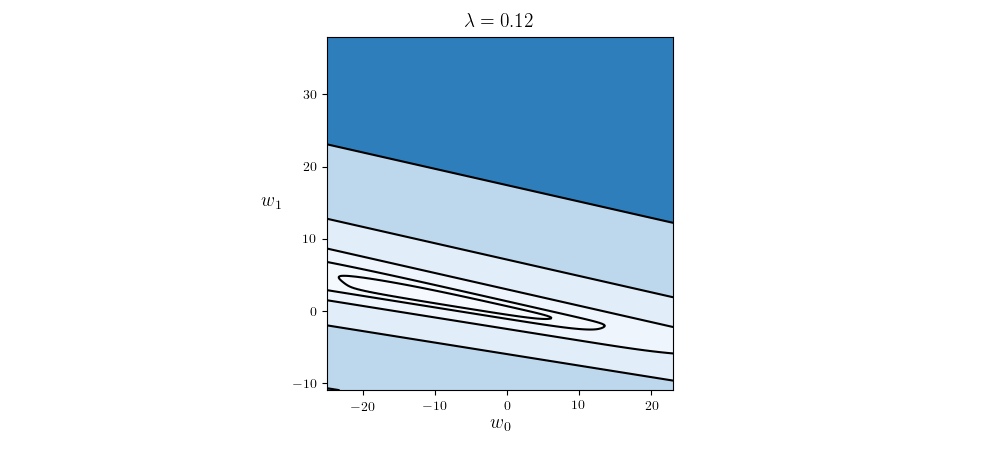
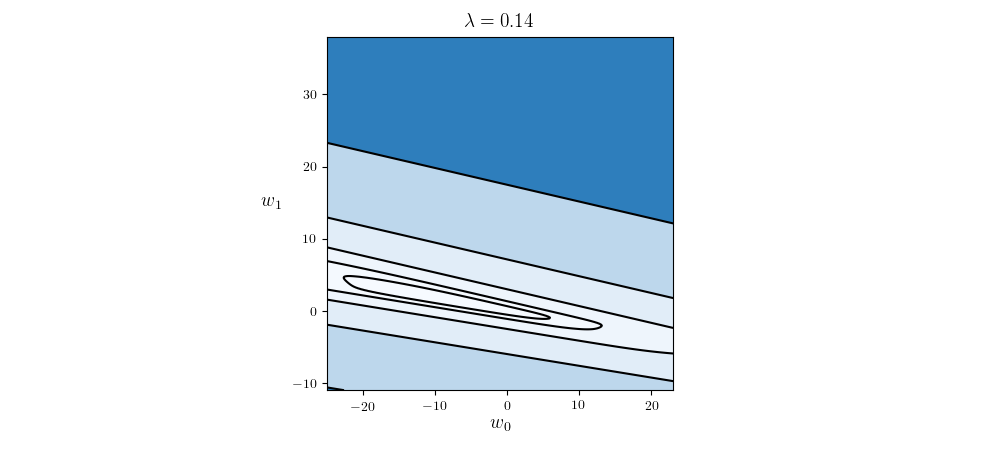
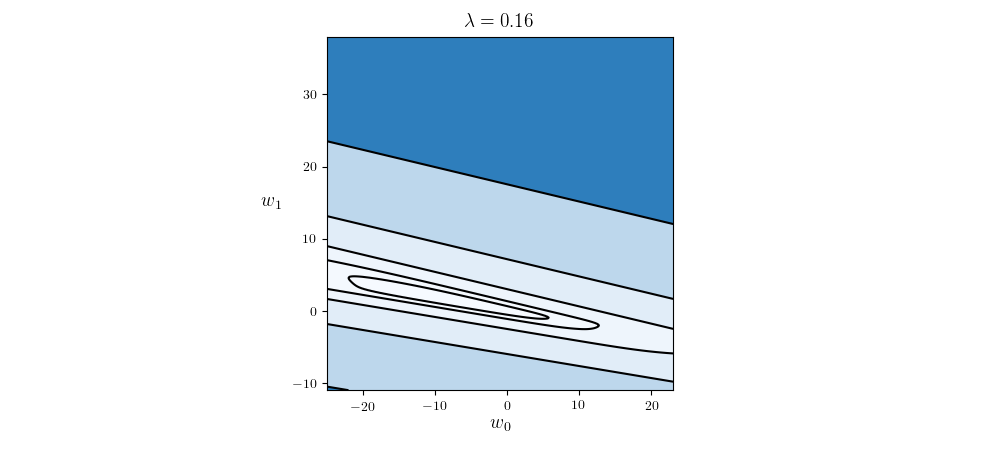
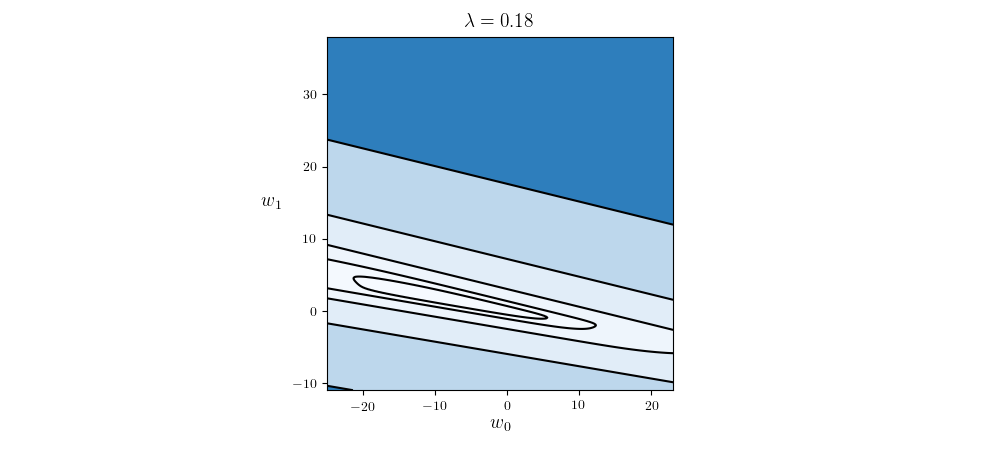
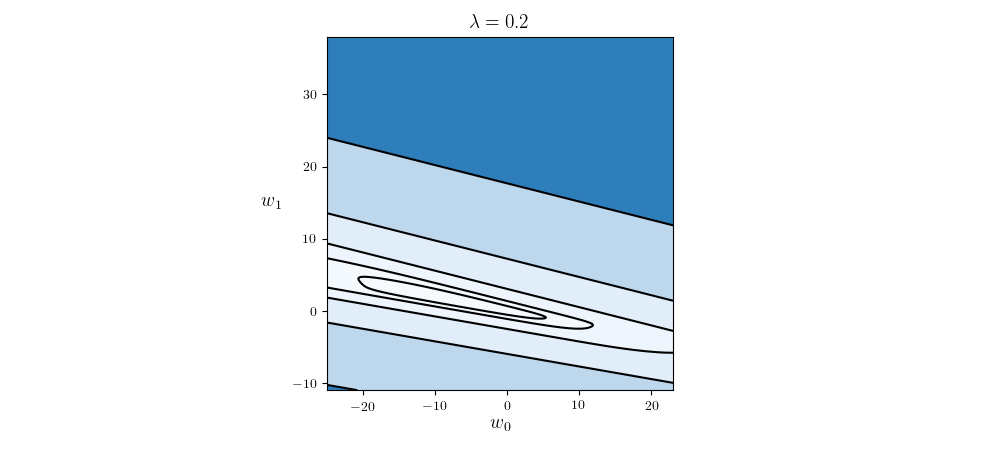
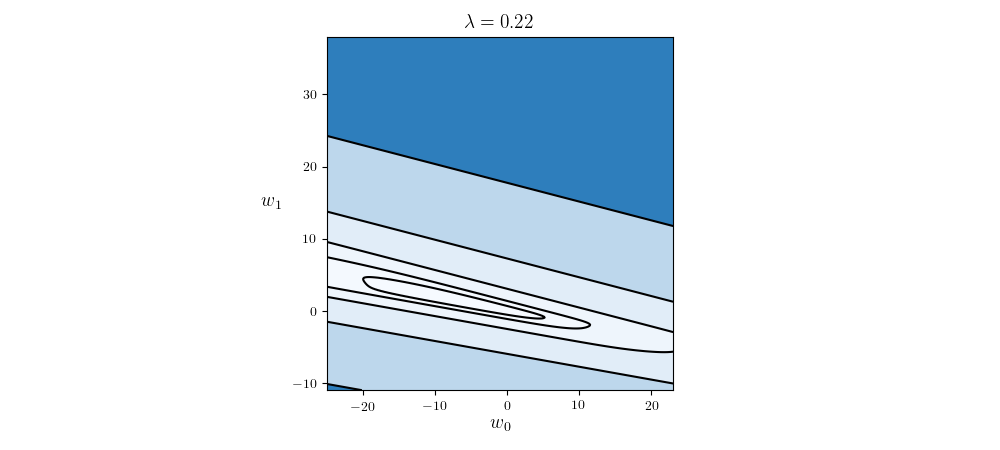
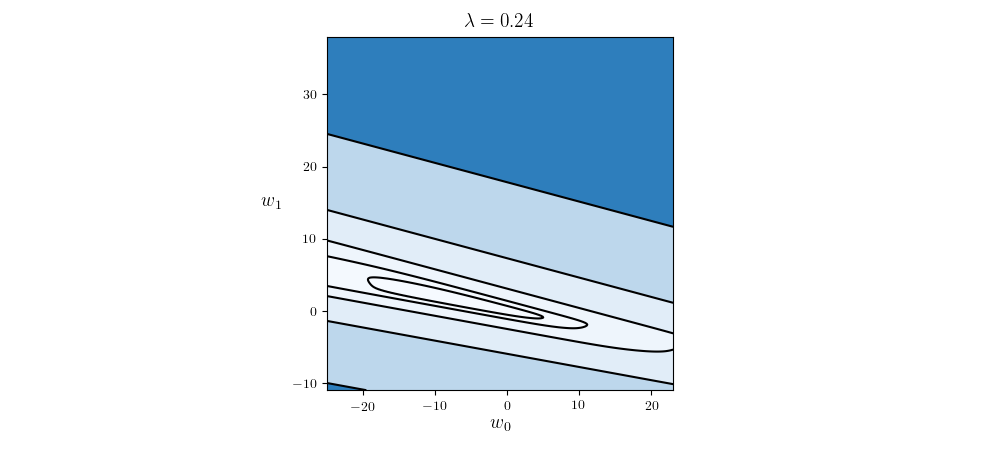
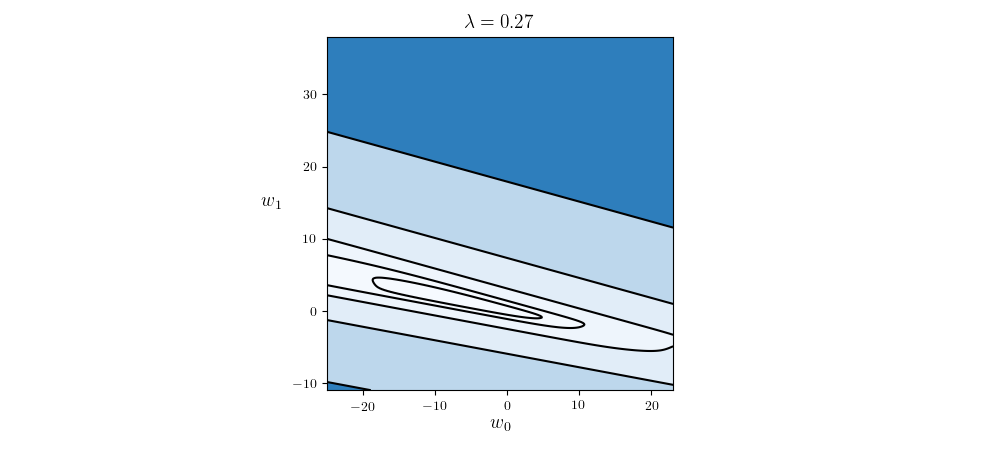
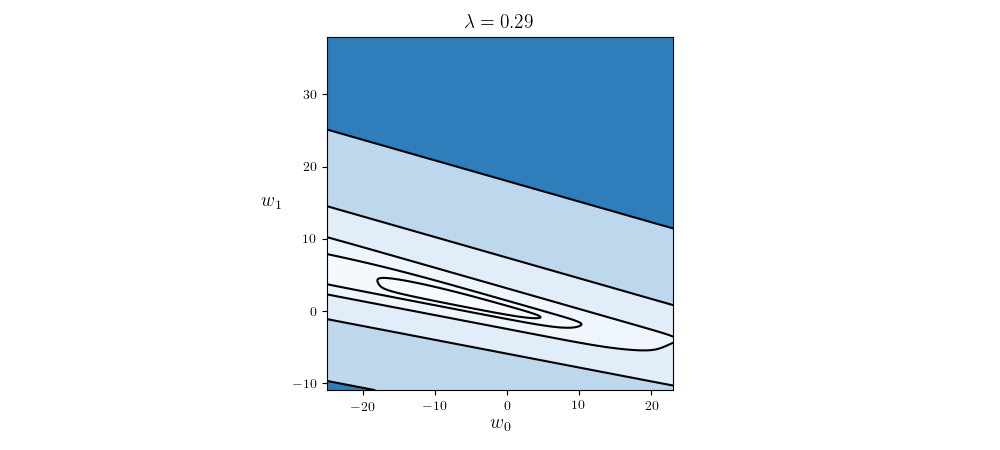
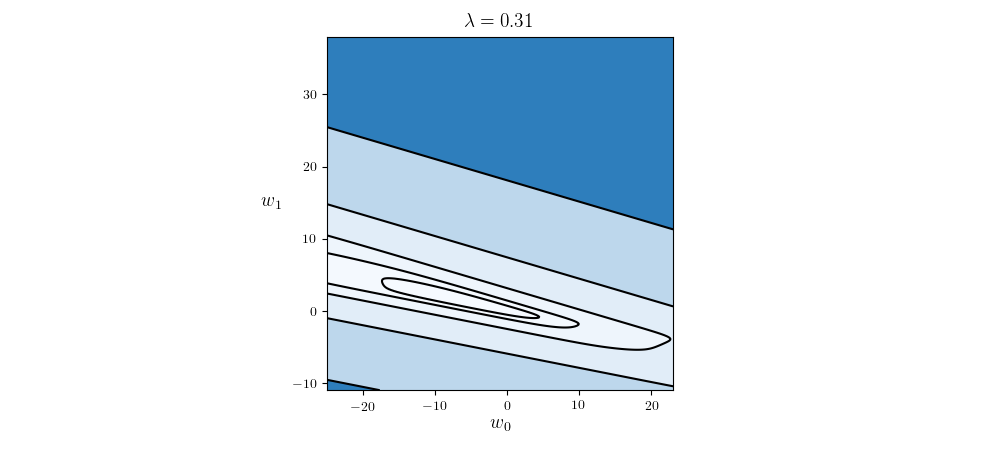
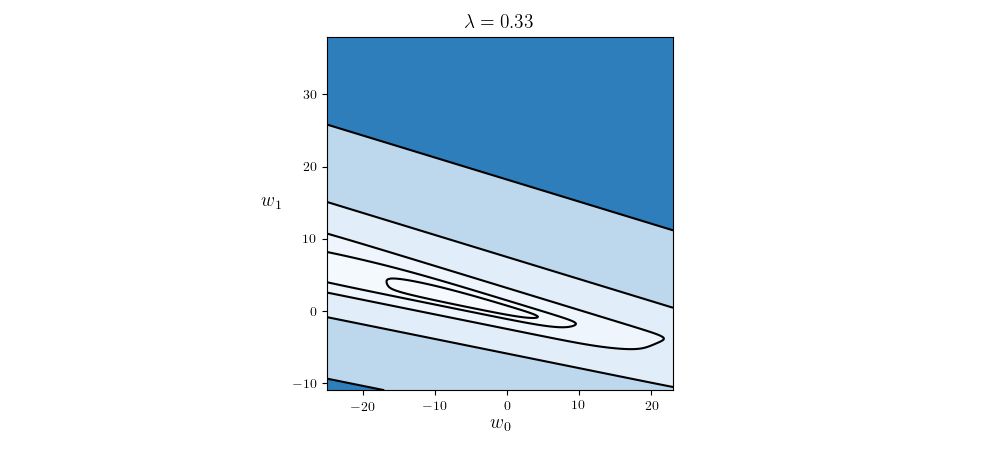
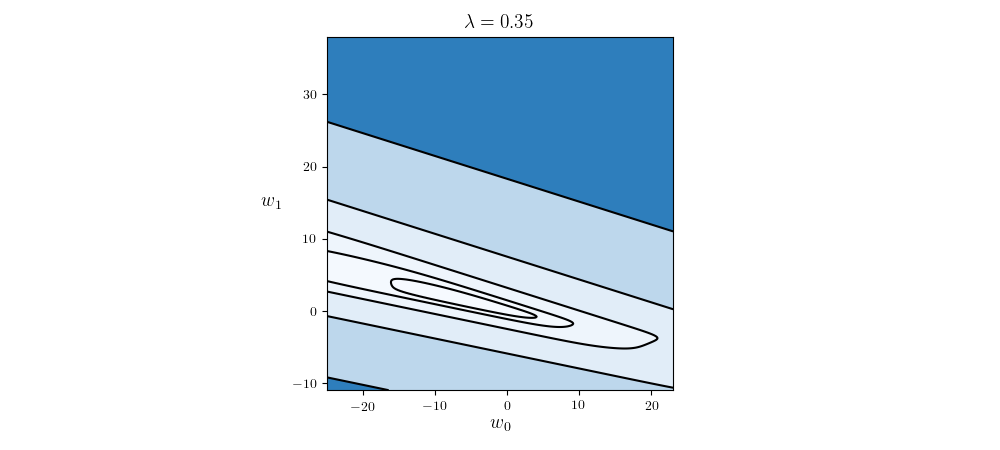
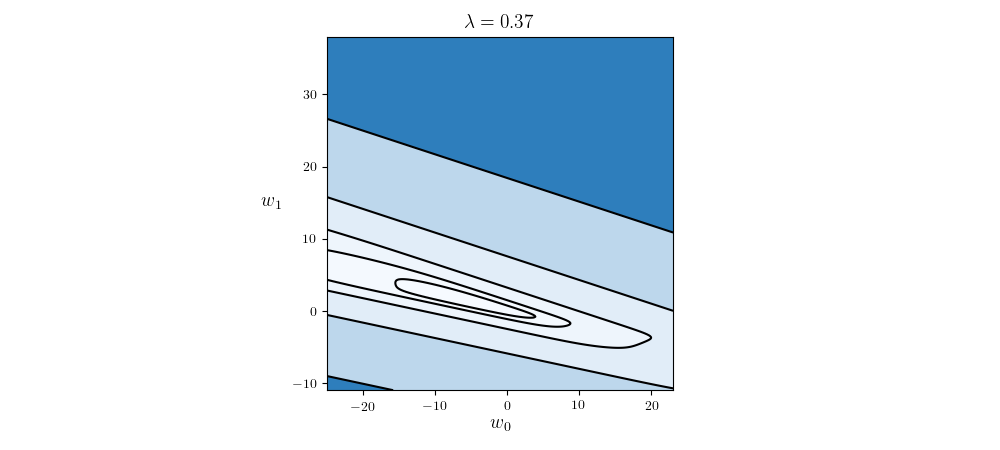
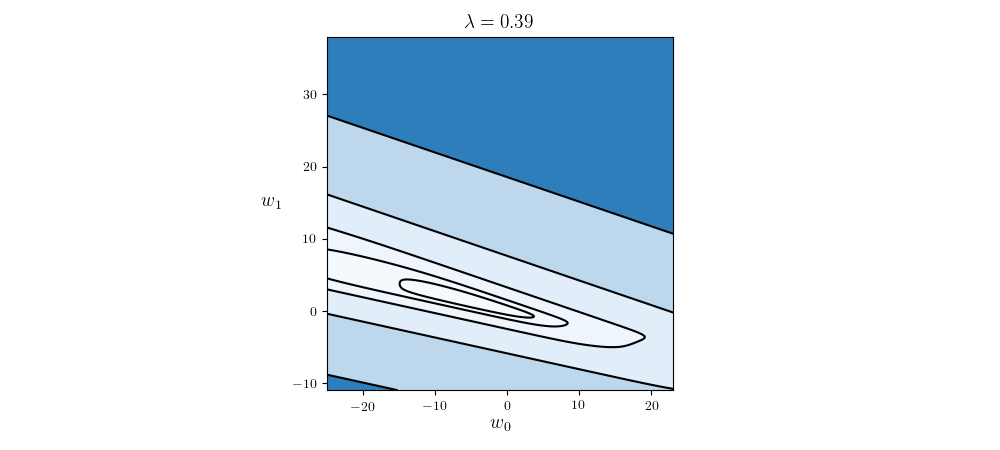
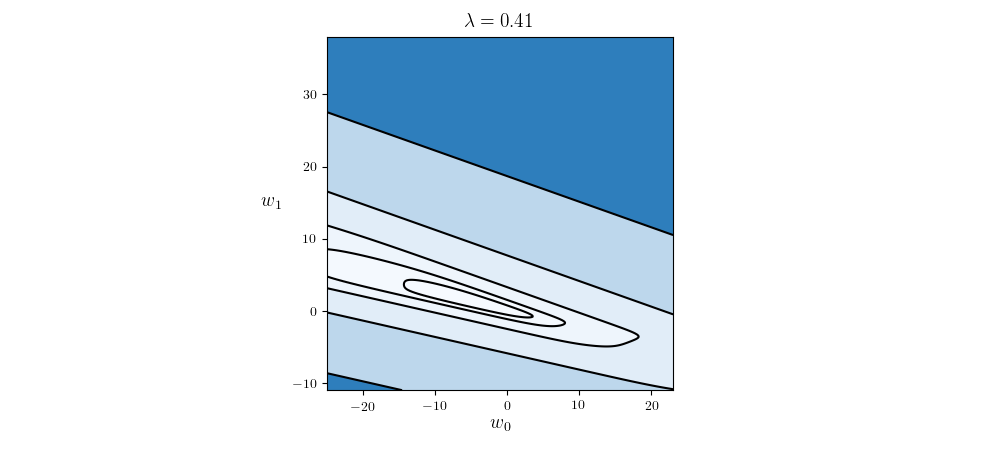
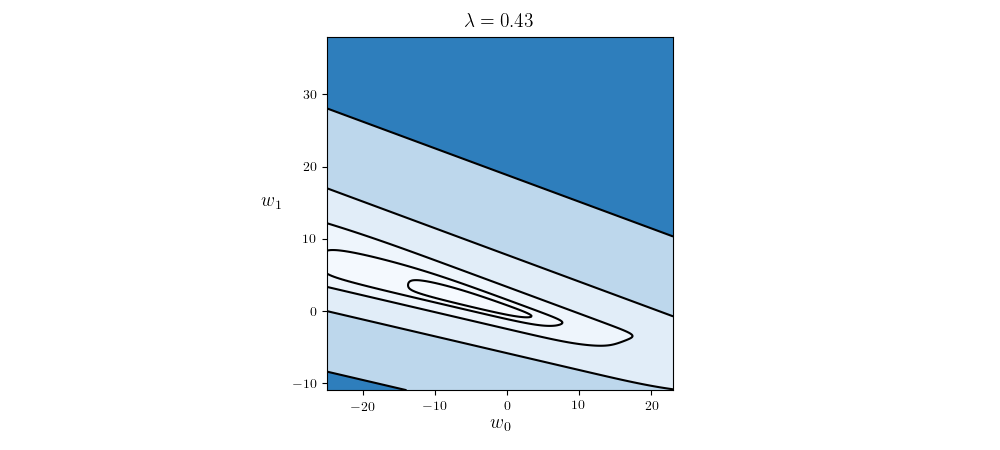
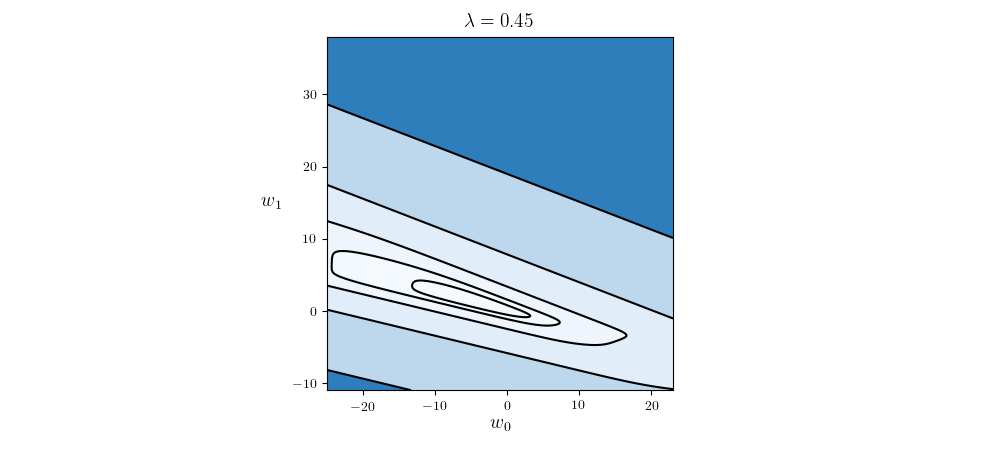
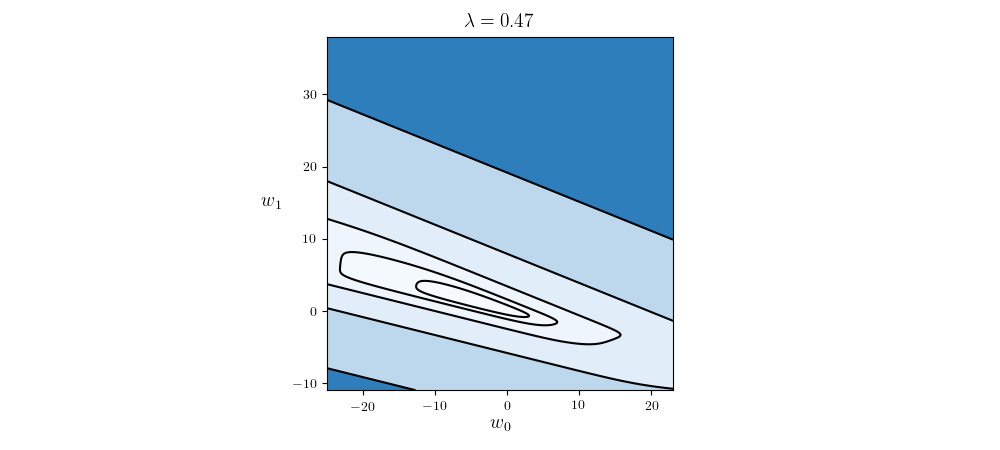
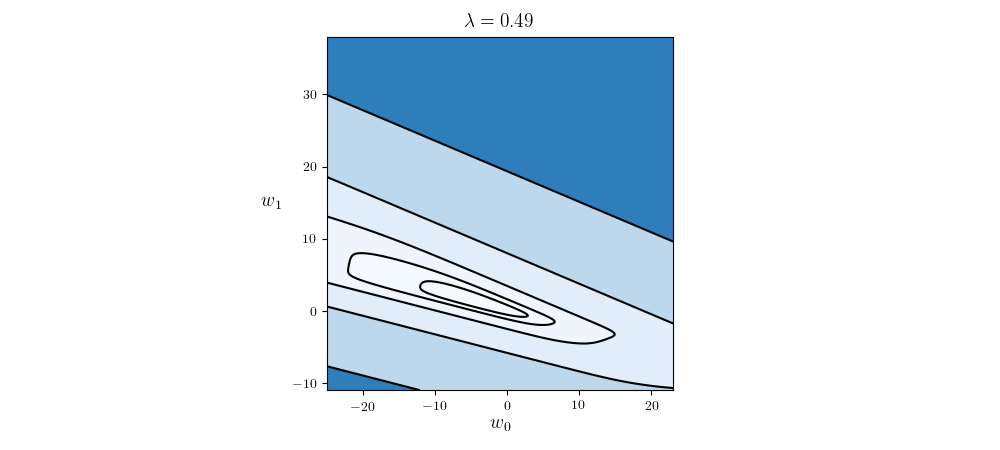
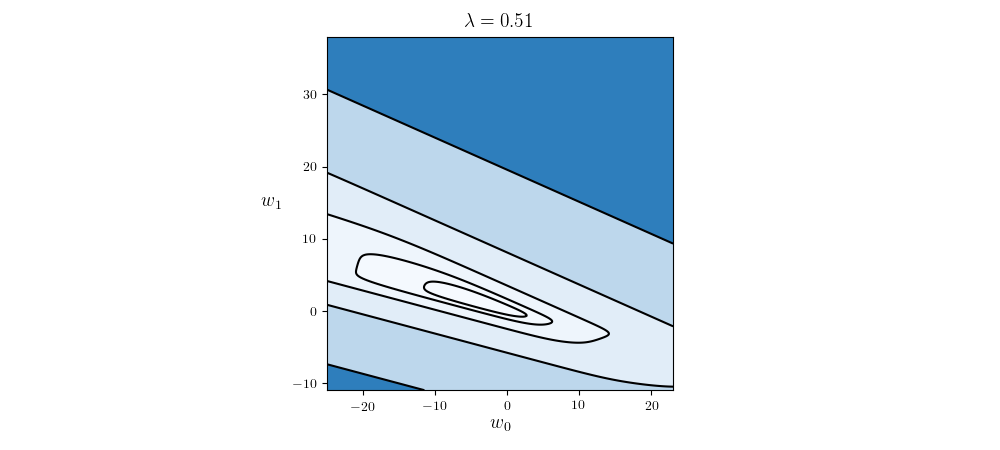
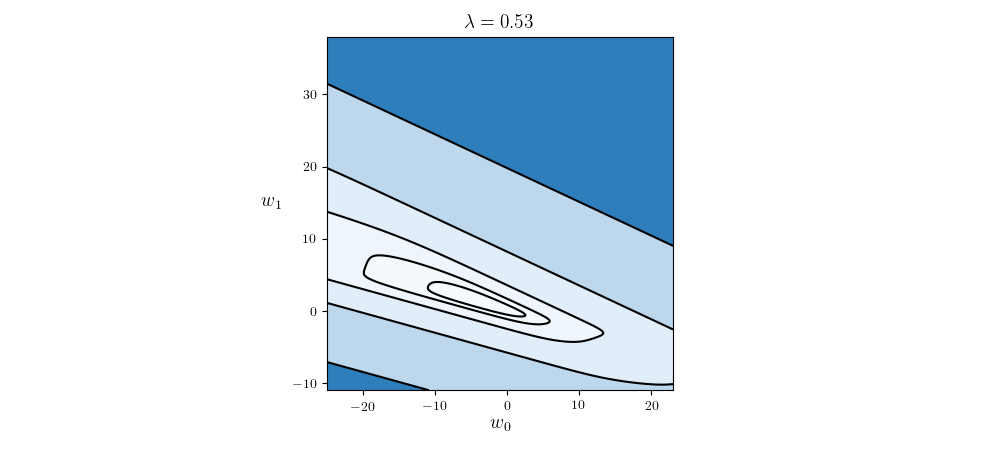
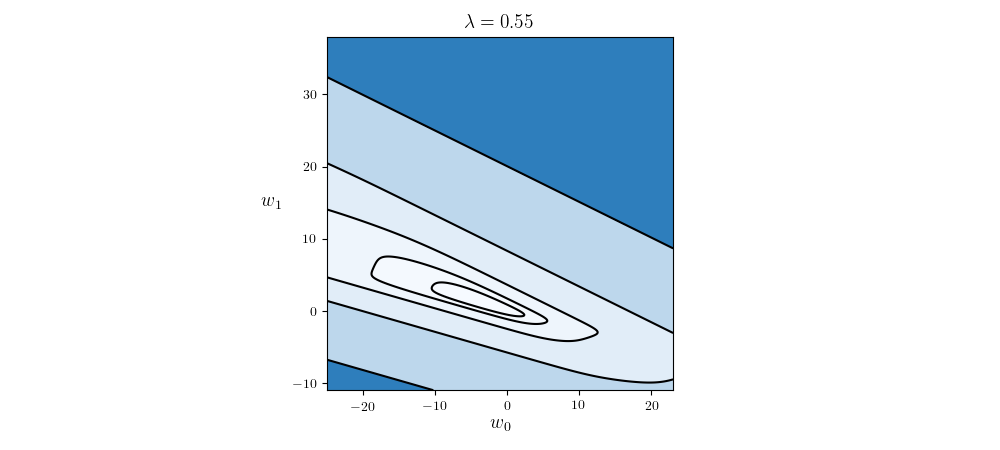
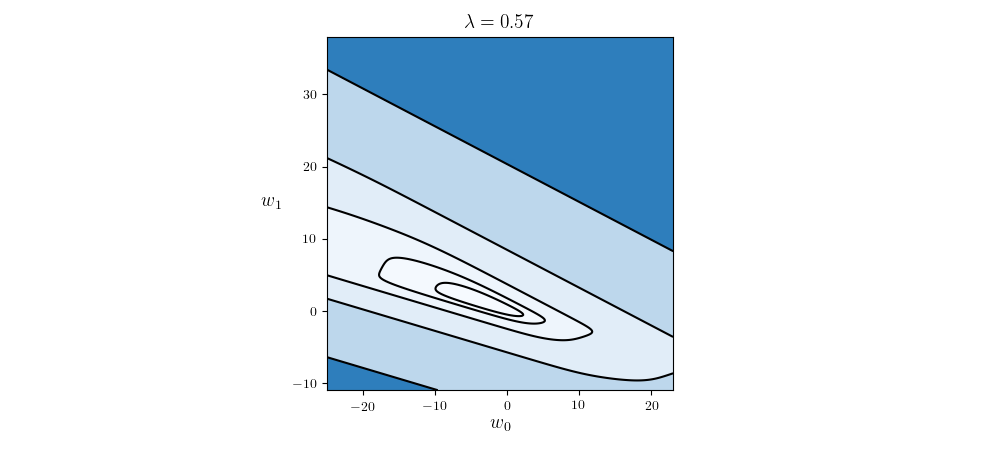
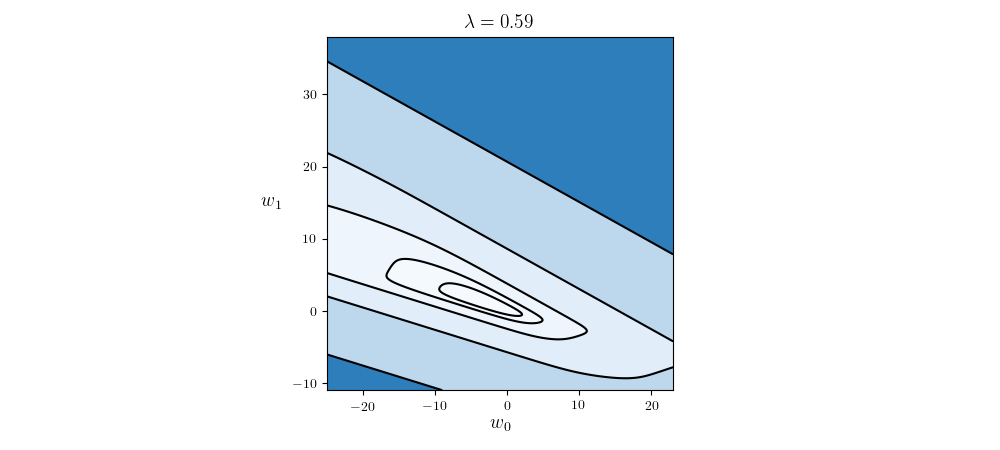
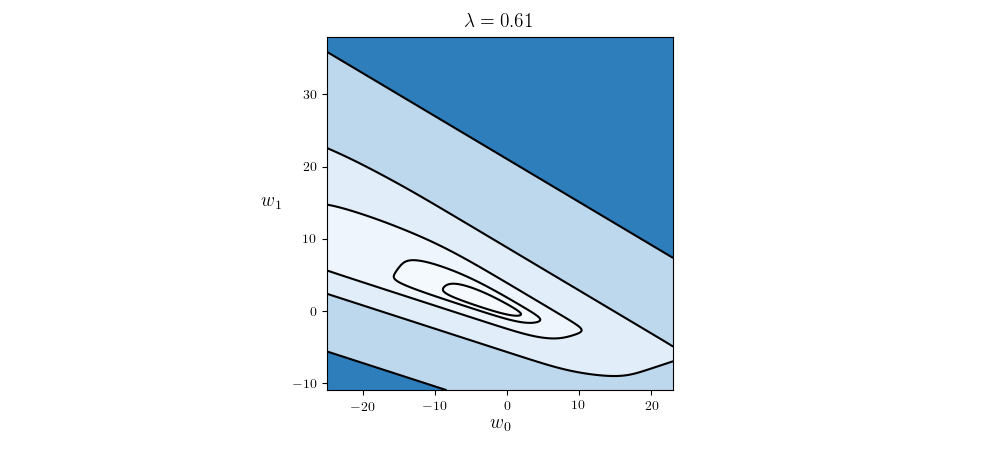
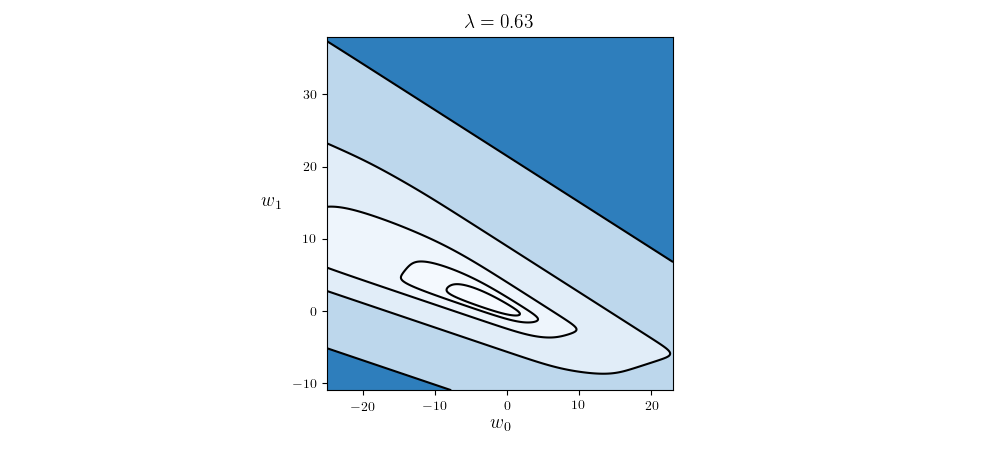
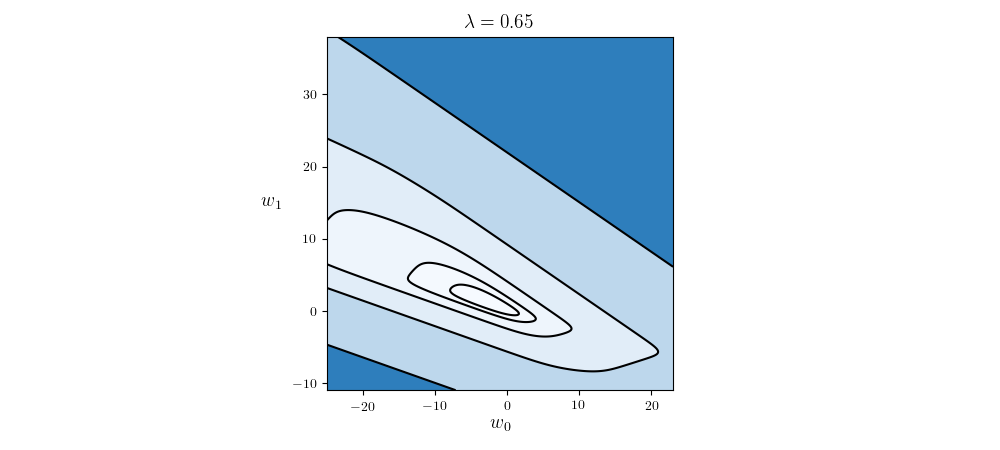
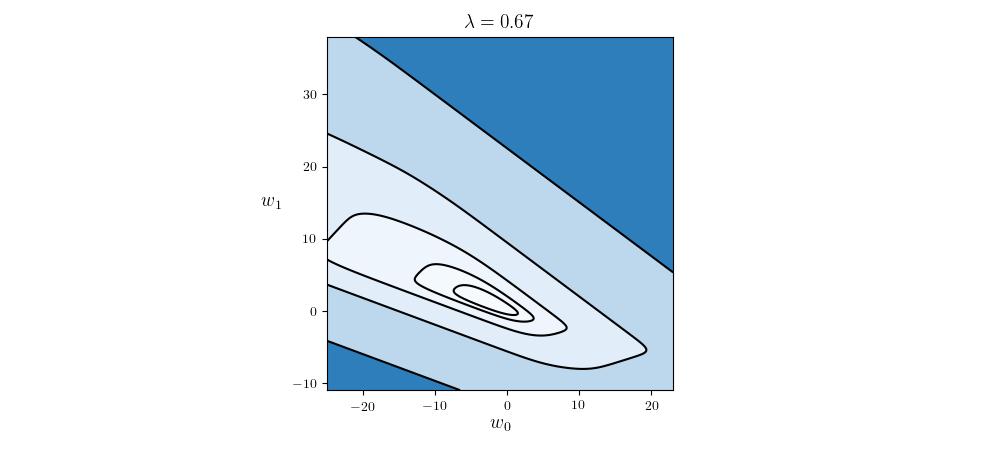
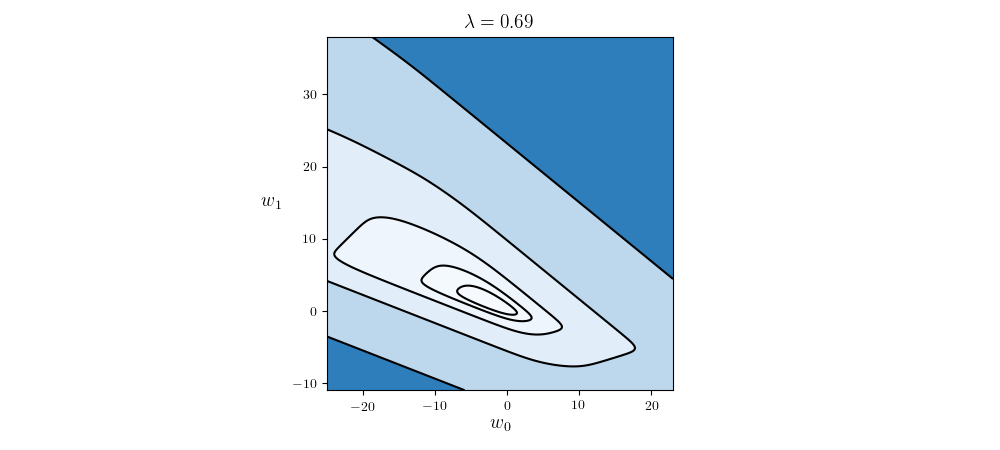
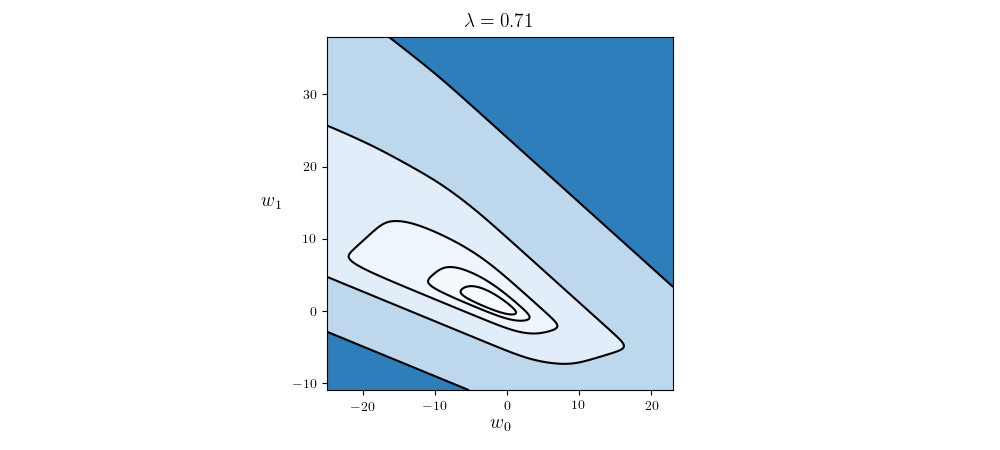
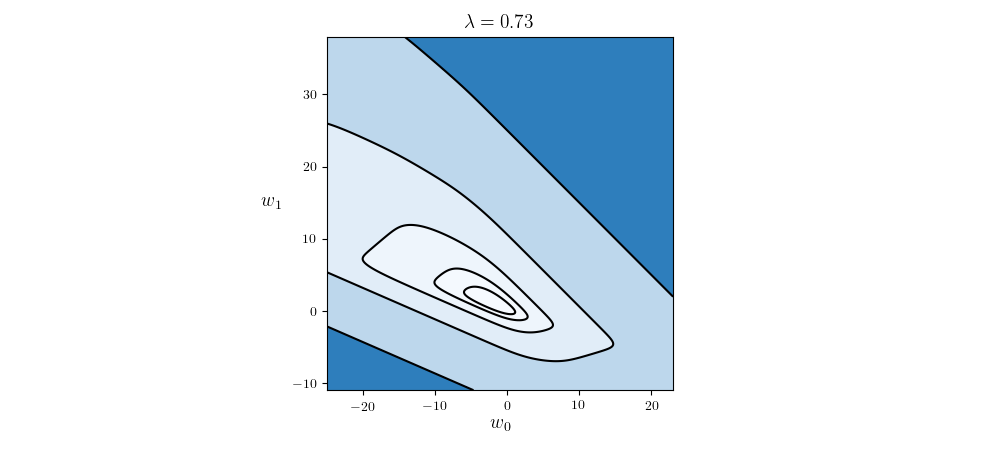
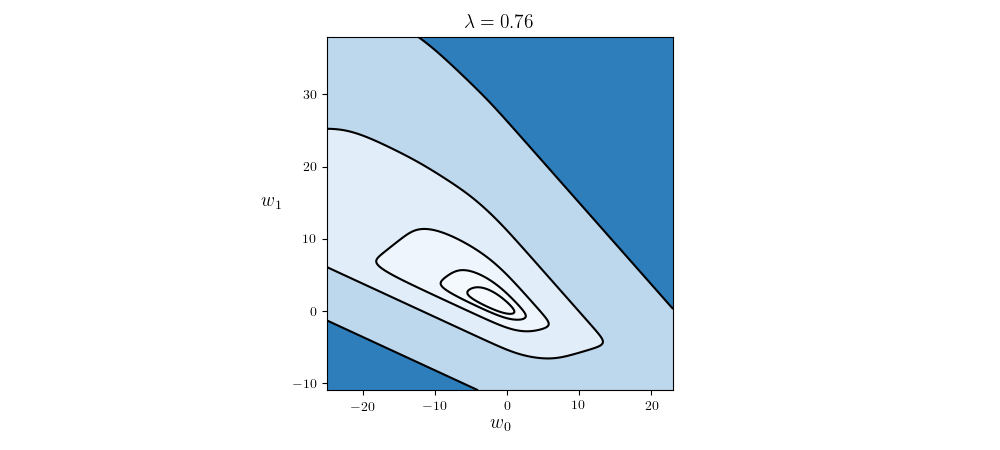
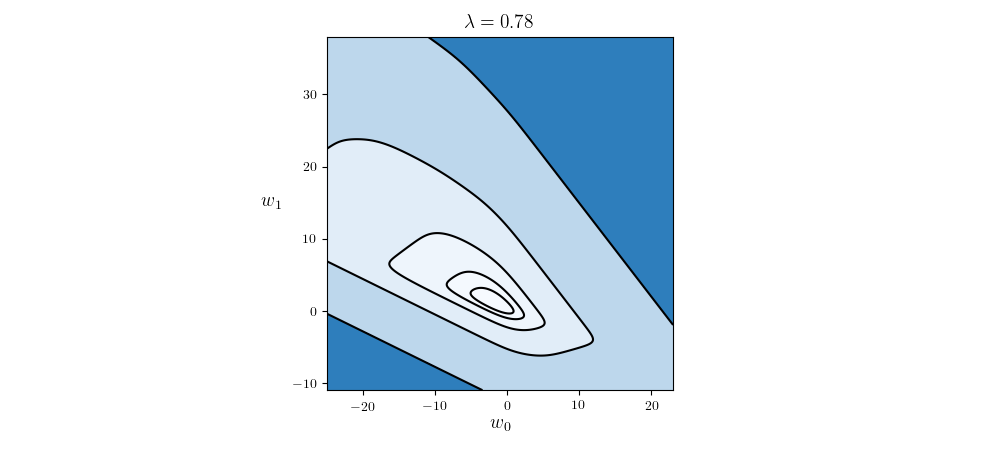
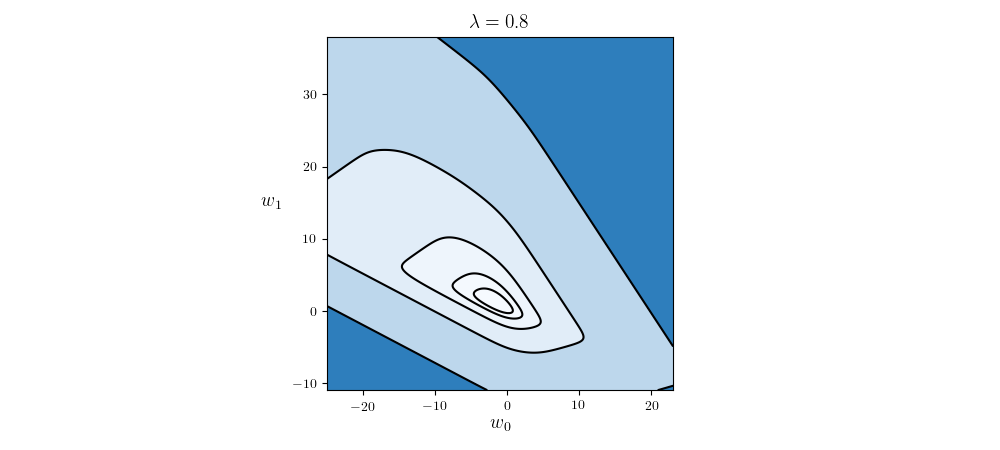
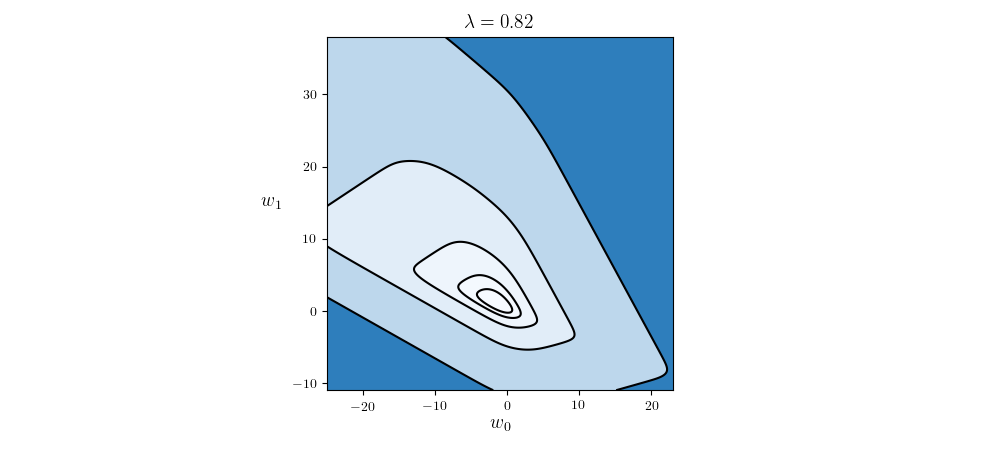
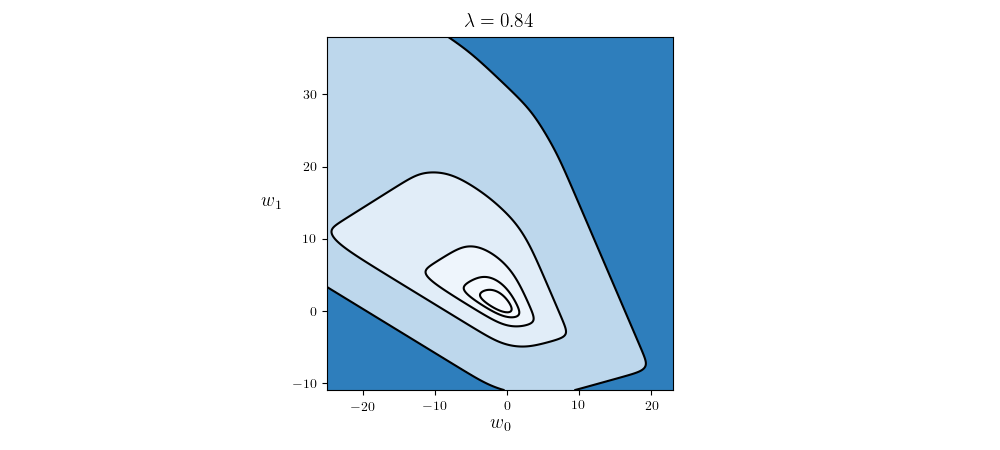
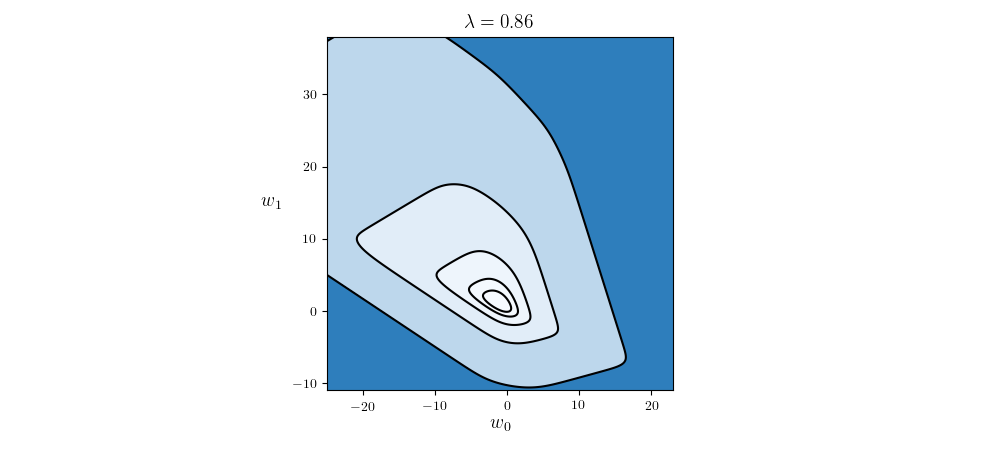
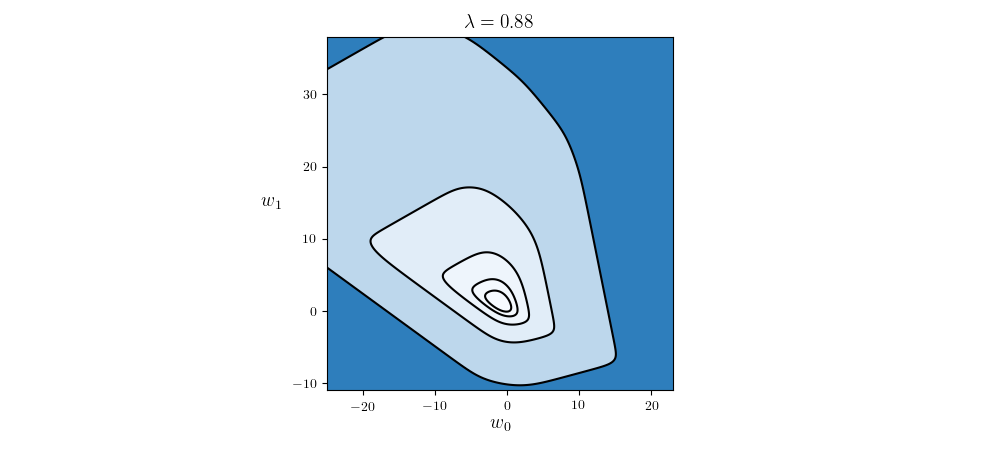
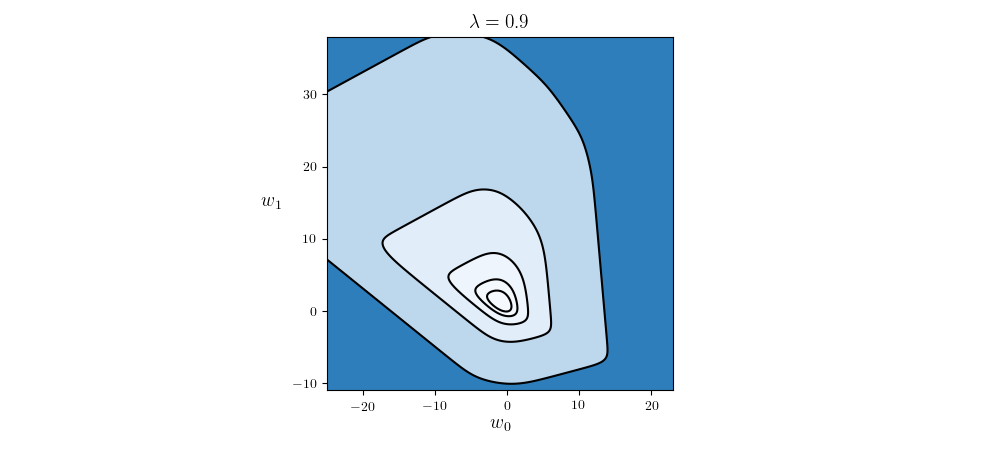
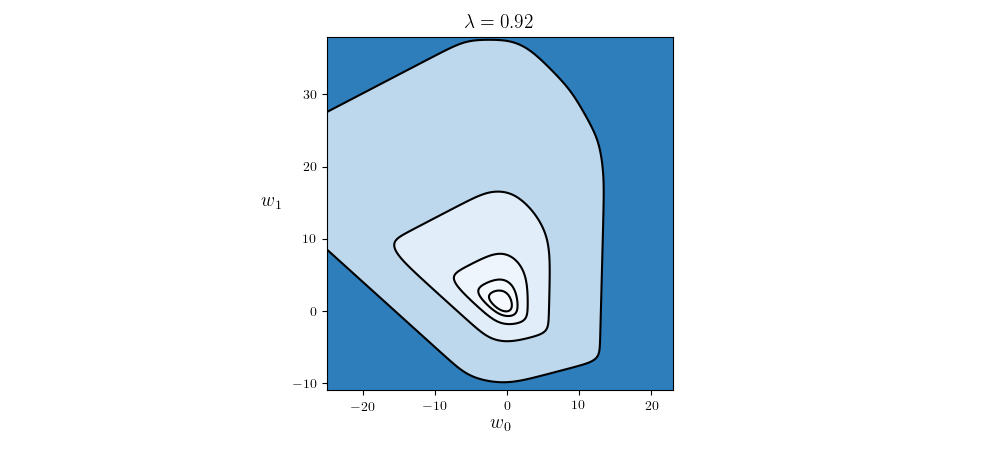
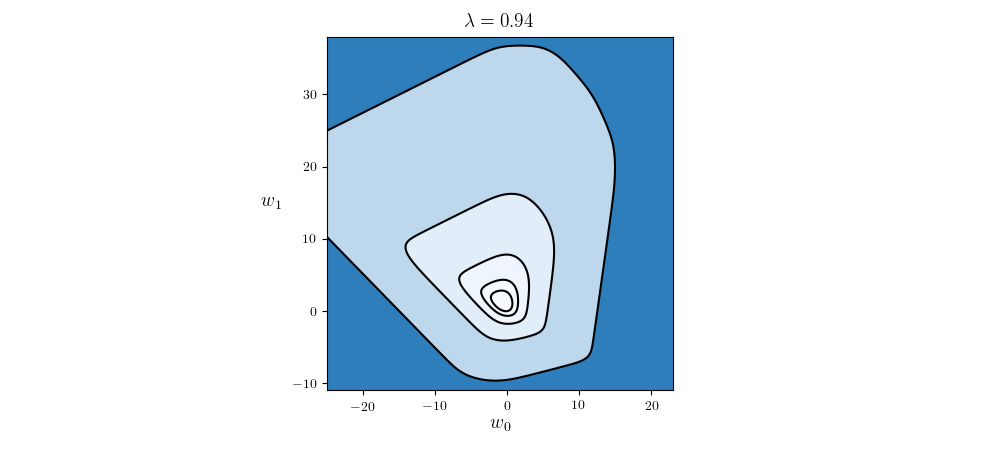
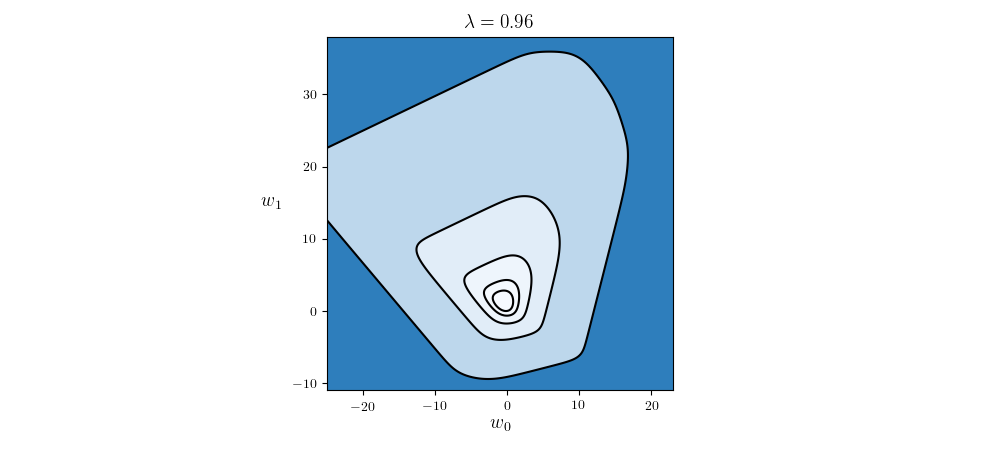
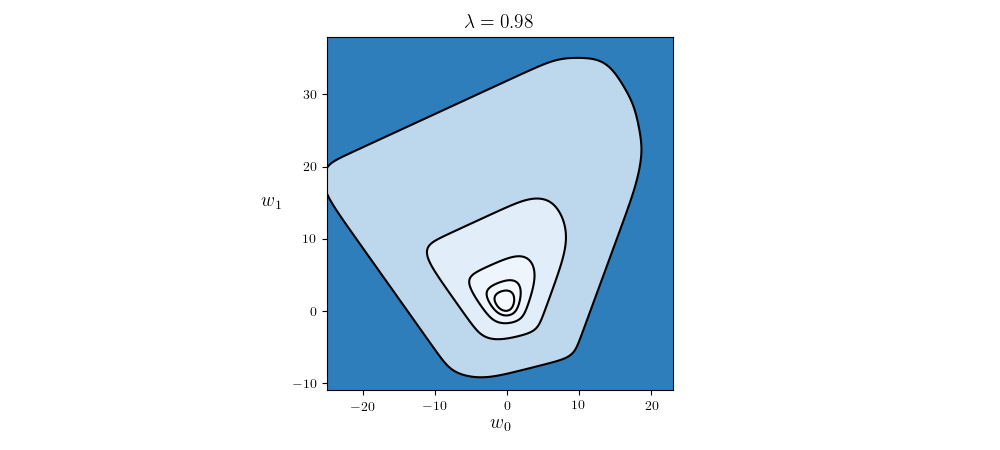
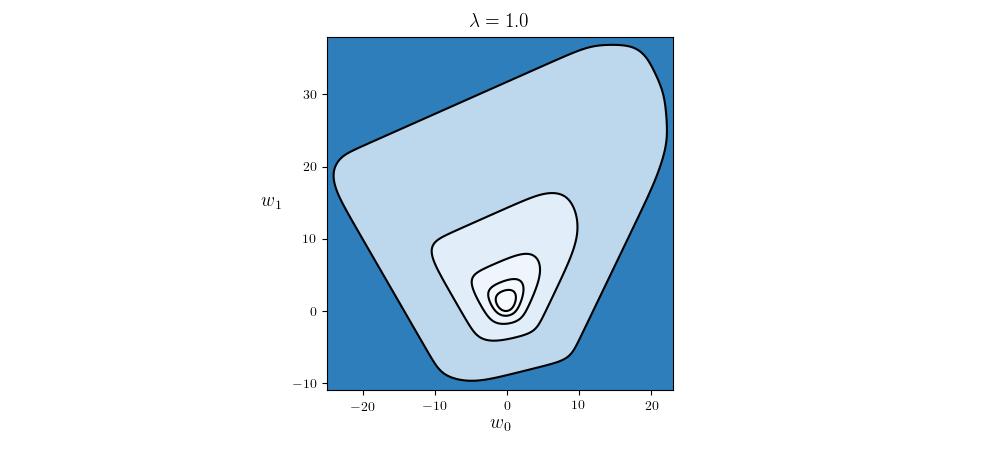

In [10]:
# animation showing cost function transformation from standard to normalized input
scaling_tool = feature_scaling_tools.Visualizer(x,x_normalized,y,'softmax')
scaling_tool.animate_transition(num_frames=50,xmin = -25,xmax = 23,ymin = -11,ymax = 38,num_contours = 5)

Now we make a run of gradient descent to find an approximate global minimum of this softmax cost.  We will initialize at precisely the same point as was done previously, and use the largest steplength of the form $10^{-\gamma}$ possible, which in this instance is $\alpha = 10$.  Whenever we normalize input like this we can always use a larger fixed steplength value.  Here - however - we will only use $25$ steps (one-fourth as many as we ran above in minimizing the softmax with un-normalized data).  Nonetheless even with so few steps - as can be seen below - we easily minimize the softmax cost and find an approximate global global minimum.

In [26]:
# load in an optimizer
g = softmax_2; w = np.array([20.0,30.0])[:,np.newaxis]; max_its = 25; alpha_choice = 10;
weight_history_2,cost_history_2 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_2 = [counting_cost(v) for v in weight_history_2]  # compute misclassification history

<IPython.core.display.Javascript object>


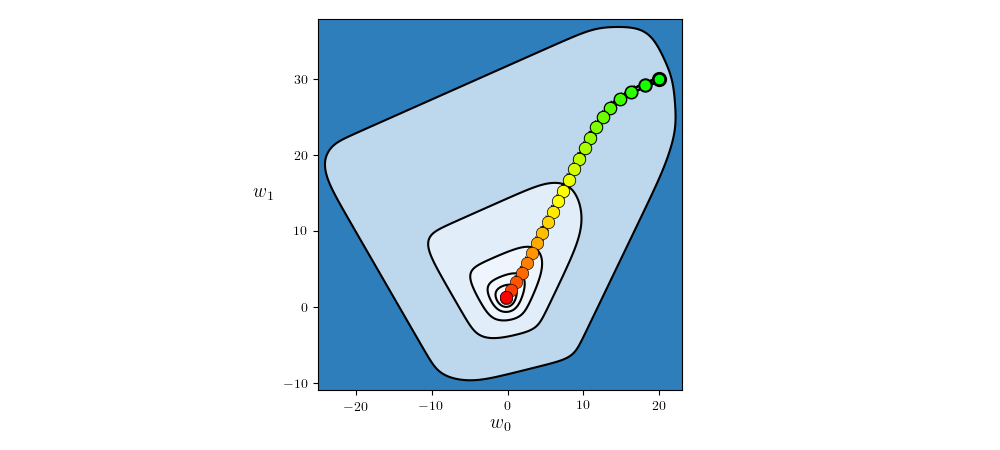

In [12]:
# s of an input function over a desired viewing range
static_plotter.two_input_contour_plot(softmax_2,weight_history_2,xmin = -25,xmax = 23,ymin = -11,ymax = 38,num_contours = 5,show_original = False)

Using only a quarter of the number of descent steps - with precisely the same setup as previously - we get *much closer* to the cost function minimum!  

Let us plot the logistic and counting cost fits associated with the final set of weights (the final red point above) on our original dataset below.   Notice - just as with linear regression - that in order to make this plot we must treat each new *input test point* on the predictor precisely as we treated our original input: i.e., we must subtract off the same mean and divide off the same standard deviation.  Thus with our fully tuned parameters $w_0^{\star}$ and $w_1^{\star}$ our linear predictor for any input point $x$ is, instead of $ w_0^{\star} + w_1^{\star}x^{\,}$, now

\begin{equation}
\text{normalized_predictor}\left(x\right) = \text{tanh}\left(w_0^{\star} + w_1^{\star}\left(\frac{x - \mu}{\sigma}\right)\right).
\end{equation}

Again - since we normalized the input data we trained on, we must normalize any new input point we shove through our trained logistic model.

The final logistic predictor and counting cost - plotted below in red and blue below respectively - is far superior to the one we found previously, where we took $4$ times as many gradient descent steps, prior to normalizing the input data.  

<IPython.core.display.Javascript object>


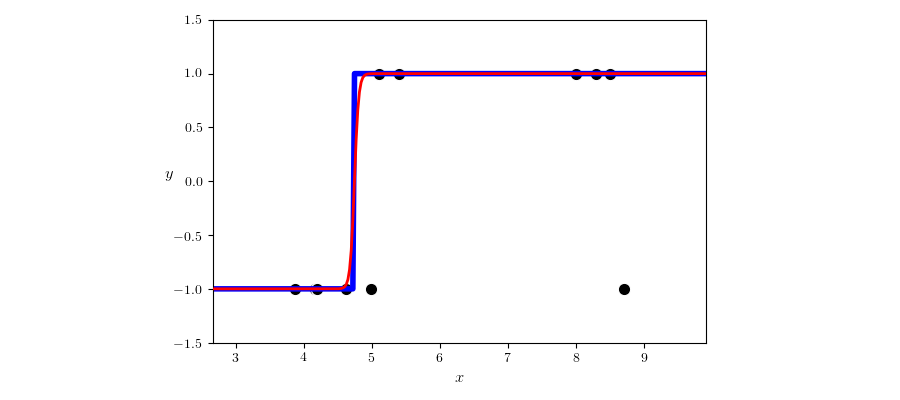

In [27]:
# the original data and the best learned logistic sigmoid and counting cost
# line learned from our gradient descent run above
ind = np.argmin(count_history_2)
best_weights = weight_history_2[ind]
demo.plot_fit(best_weights,transformer = normalizer)

## 8.4.2 Feature scaling for multi-input datasets

As with linear regression, with two class classification when dealing with $N$ dimensional input datasets we can normalize each input feature precisely as we did above, and gain the same sort of benefit in terms of speeding up gradient descent.  This means we mean normalize and divide off the standard deviation a long each input axis, replacing each coordinate of our input data as

\begin{equation}
x_{p,n} \longleftarrow \frac{x_{p,n} - \mu_n}{\sigma_n}
\end{equation}

where $x_{p,n}$ is the $n^{th}$ coordinate of the $p^{th}$ input point and $\mu_n$ and $\sigma_n$ are the mean and standard deviation of the $n^{th}$ dimension of the data, respectively, and are defined as 

\begin{array}
\
\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n} \\
\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_{p,n} - \mu_n \right)^2}.
\end{array}

Below we will compare a run of gradient descent on standard and normalized data using a real $N = 8$ input breast cancer dataset, a description of which you can find [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).  Below we load in the data, run gradient descent, and then normalize the input and do the same.  Afterwards we compare the two runs.

In [14]:
# load in dataset
data = np.loadtxt(datapath + 'breast_cancer_data.csv',delimiter = ',')

# get input/output pairs
x = data[:,:-1:].T 
y = data[:,-1:] 

Below we run gradient descent for $100$ iterations, using $\alpha = 10^{-1}$ the largest steplength parameter of the form $10^{-\gamma}$ that produced convergence.

In [15]:
# load in cost function
softmax = cost_lib.Setup(x,y,'softmax').cost_func
counting_cost = cost_lib.Setup(x,y,'counter').cost_func

# load in an optimizer
g = softmax; w = 0.1*np.random.randn(x.shape[0]+1,1); max_its = 100; alpha_choice = 10**(-1);
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_1 = [counting_cost(v) for v in weight_history_1]

Now we normalize the input and create corresponding softmax and counting cost functions.

In [16]:
# create normalizer/inverse normalizer
normalizer = normalizers.standard_normalizer(x)

# normalize input
x_normalized = normalizer(x)

# make new costs for normalized data
softmax_2 = cost_lib.Setup(x_normalized,y,'softmax').cost_func
counting_cost_2 = cost_lib.Setup(x_normalized,y,'counter').cost_func

Now we perform the same run, using the same initial point and number of descent steps used above.

In [17]:
# load in an optimizer
g = softmax_2; alpha_choice = 1;
weight_history_2,cost_history_2 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_2 = [counting_cost_2(v) for v in weight_history_2]

Below we plot the cost and misclassification histories from our two runs of gradient descent.  As can be seen, the run on the normalized input (in magenta) converges much faster.

<IPython.core.display.Javascript object>


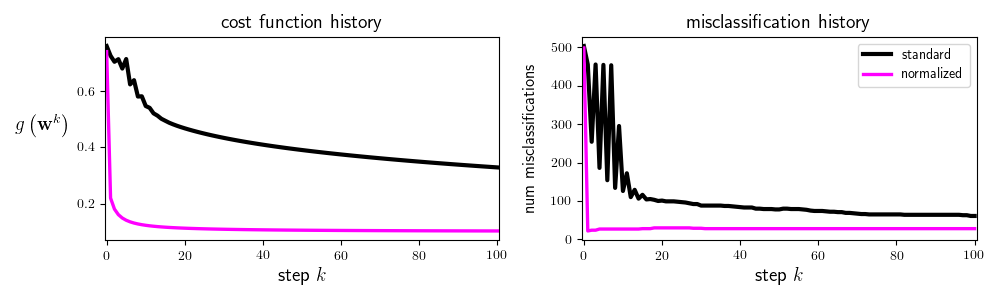

In [18]:
# plot the cost function history for a given run
classification_plotter.plot_cost_histories([cost_history_1,cost_history_2],[count_history_1,count_history_2],start = 0,labels = ['standard','normalized'])

Note to evaluate any new test point $\mathbf{x}$ - using our fully tuned parameters $w_0^{\star},w_1^{\star},...,w_N^{\star}$,we have to treat it as we did our training data - by normalizing each input feature using the same statistics we computed on the training data above.

\begin{equation}
\text{normalized_predictor}\left(\mathbf{x}\right) = \text{tanh}\left(w_0^{\star} + w_1^{\star}\left(\frac{x_1 - \mu_1}{\sigma_1}\right) + w_2^{\star}\left(\frac{x_2 - \mu_2}{\sigma_2}\right) + \cdots + w_N^{\star}\left(\frac{x_N - \mu_N}{\sigma_N}\right)\right).
\end{equation}